# 毕业论文`GRAD`
## `MCIP`气象场分析

---
*@author: Evan*\
*@date: 2023-11-01*

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import sys
sys.path.append('../../../src/')
from namelist import *
from mask import polygon_to_mask, average_data

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

## 计算平均值数组

In [2]:
var = 'WSPD10'
month = "Sep"

low_years = np.array([2016,2015,2014])
high_years = np.array([2022,2021,2019])

low_files  = [os.path.join(processed_dir, f"{month}_{year}/{month}_{year}_mcip.nc") for year in low_years]
high_files = [os.path.join(processed_dir, f"{month}_{year}/{month}_{year}_mcip.nc") for year in high_years]
low_files

['D:/data/Graduation/processed/Sep_2016/Sep_2016_mcip.nc',
 'D:/data/Graduation/processed/Sep_2015/Sep_2015_mcip.nc',
 'D:/data/Graduation/processed/Sep_2014/Sep_2014_mcip.nc']

In [3]:
avg_low  = average_data(low_files, var)
avg_high = average_data(high_files, var)

In [4]:
hours = avg_low['time'].dt.hour
daytime_indices = (hours >= 8) & (hours <= 17)
nighttime_indices = (hours < 8) | (hours >= 18)

day_low    = avg_low.sel(time = daytime_indices)
day_high   = avg_high.sel(time = daytime_indices)
night_low  = avg_low.sel(time = nighttime_indices)
night_high = avg_high.sel(time = nighttime_indices)

print(day_low.shape)
print(night_low.shape)

(300, 110, 152)
(420, 110, 152)


## 计算珠三角范围平均

In [5]:
shp = gpd.read_file(shp_PRD_adm)
lon = avg_low.longitude
lat = avg_low.latitude

mask    = polygon_to_mask(shp.geometry[0], lon, lat)
mask_da = xr.DataArray(mask, dims=('y','x'))

masked       = day_low.where(mask_da)
avg_day_low  = masked.mean(dim=('x','y'),skipna=True)
masked       = day_high.where(mask_da)
avg_day_high = masked.mean(dim=('x','y'),skipna=True)

masked         = night_low.where(mask_da)
avg_night_low  = masked.mean(dim=('x','y'),skipna=True)
masked         = night_high.where(mask_da)
avg_night_high = masked.mean(dim=('x','y'),skipna=True)

print(avg_day_low.shape)
print(avg_night_low.shape)

(300,)
(420,)


In [6]:
# percentile

# day
mean_day_low  = avg_day_low.resample(time='D').mean(skipna=True)
day_low_80per = avg_day_low.resample(time='D').quantile(0.8,skipna=True)
day_low_20per = avg_day_low.resample(time='D').quantile(0.2,skipna=True)

mean_day_high  = avg_day_high.resample(time='D').mean(skipna=True)
day_high_80per = avg_day_high.resample(time='D').quantile(0.8,skipna=True)
day_high_20per = avg_day_high.resample(time='D').quantile(0.2,skipna=True)

# night
mean_night_low  = avg_night_low.resample(time='D').mean(skipna=True)
night_low_80per = avg_night_low.resample(time='D').quantile(0.8,skipna=True)
night_low_20per = avg_night_low.resample(time='D').quantile(0.2,skipna=True)

mean_night_high  = avg_night_high.resample(time='D').mean(skipna=True)
night_high_80per = avg_night_high.resample(time='D').quantile(0.8,skipna=True)
night_high_20per = avg_night_high.resample(time='D').quantile(0.2,skipna=True)


### 拼图

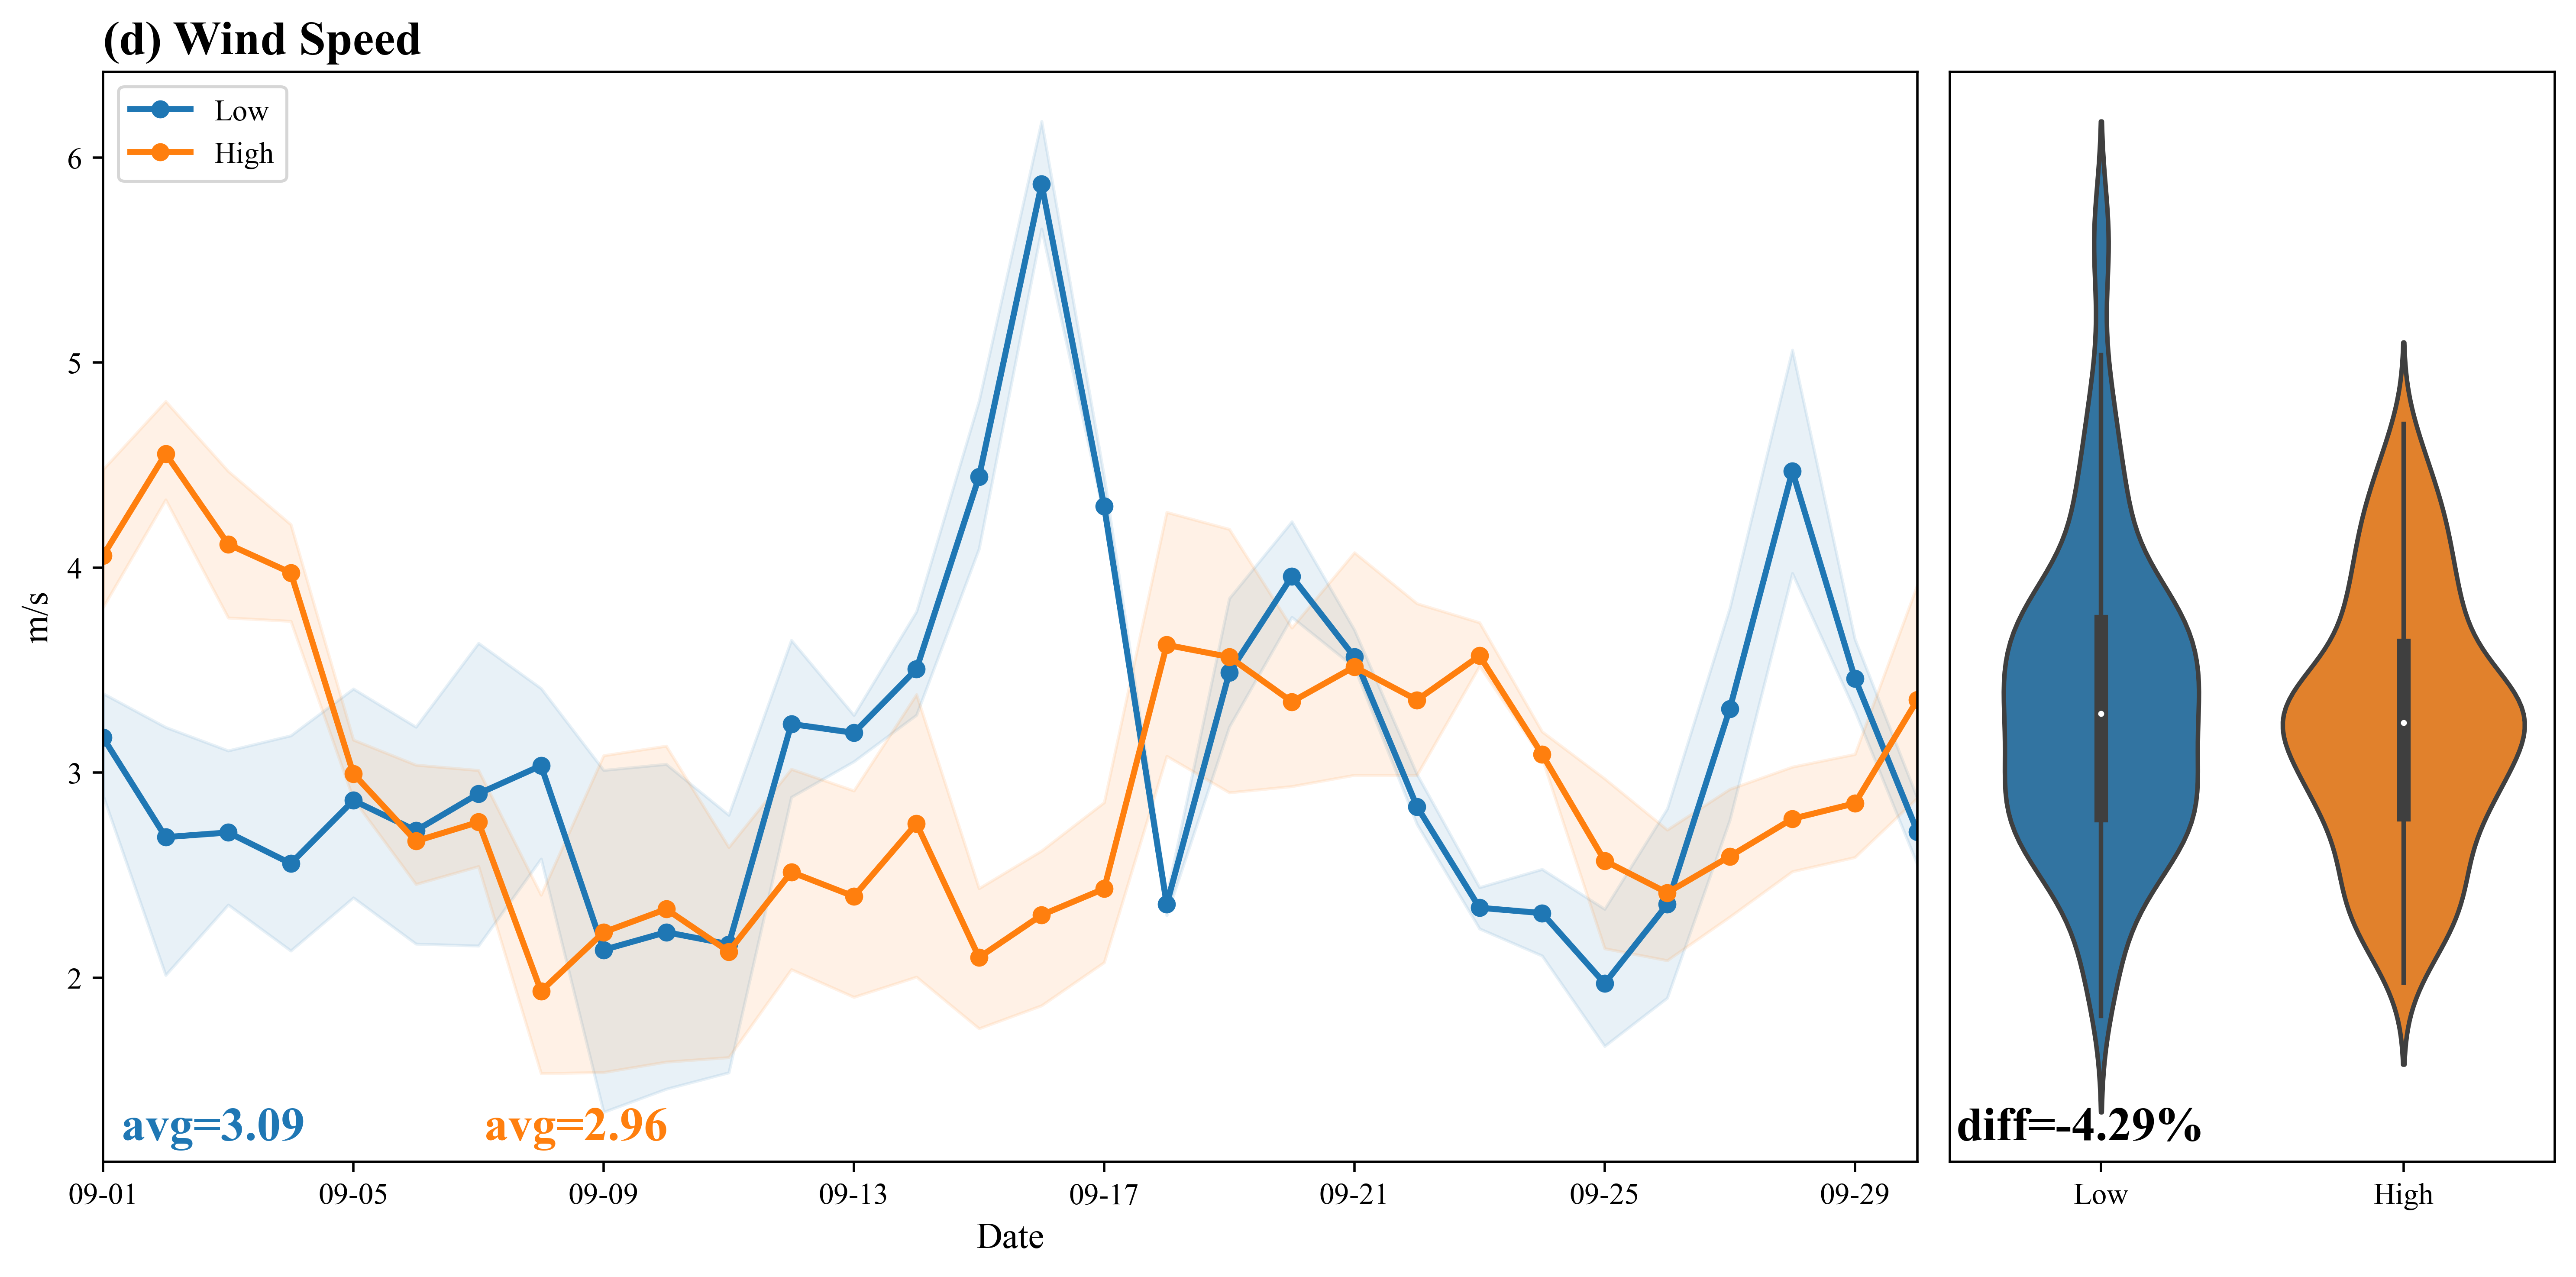

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=500, gridspec_kw={'width_ratios': [3, 1]})

xx = np.arange(0, len(mean_day_low.time), 1)
# lower years
ax1.plot(xx, mean_day_low, color='tab:blue', linewidth=2, label='Low', marker='.', markersize=10)
ax1.fill_between(xx, day_low_80per, day_low_20per, color='tab:blue', alpha=0.1)

ax1.plot(xx, mean_day_high, color='tab:orange', linewidth=2, label='High', marker='.', markersize=10)
ax1.fill_between(xx, day_high_80per, day_high_20per, color='tab:orange', alpha=0.1)

# ticks and labels
ax1.set_xlim([0, len(mean_day_low.time) - 1])
ax1.set_xticks(xx[::4])
ax1.set_xticklabels(pd.date_range('2023-09-01', '2023-09-30', freq='4D').strftime('%m-%d'))
ax1.set_xlabel('Date',fontsize=12)
ax1.set_ylabel('m/s',fontsize=12)
ax1.legend(loc=2)
ax1.set_title('(d) Wind Speed', loc='left', fontdict={'fontsize': 16, 'fontweight': 'bold'})

# 添加平均值数字
strdict = {'fontsize': 16, 'fontweight': 'bold'}
avg_low_str = '{:.2f}'.format(avg_day_low.mean())
avg_high_str = '{:.2f}'.format(avg_day_high.mean())
ax1.text(x=0.01, y=0.02, s=f'avg={avg_low_str}', color='tab:blue', fontdict=strdict, transform=ax1.transAxes)
ax1.text(x=0.21, y=0.02, s=f'avg={avg_high_str}', color='tab:orange', fontdict=strdict, transform=ax1.transAxes)

diff_str = '{:.2f}'.format((avg_day_high.mean() - avg_day_low.mean()) / avg_day_low.mean() *100)
if float(diff_str)>0:
    ax2.text(x=0.01, y=0.02, s=f'diff=+{diff_str}%', color='k', fontdict=strdict, transform=ax2.transAxes)
else:
    ax2.text(x=0.01, y=0.02, s=f'diff={diff_str}%', color='k', fontdict=strdict, transform=ax2.transAxes)
    
# 图2：小提琴图
df_box = pd.DataFrame({'Low': avg_day_low.values, 'High': avg_day_high.values})

color_palette = sns.color_palette(["tab:blue", "tab:orange"])
sns.violinplot(data=df_box, palette=color_palette, ax=ax2)

ax2.set_yticks([])

plt.tight_layout()
plt.show()

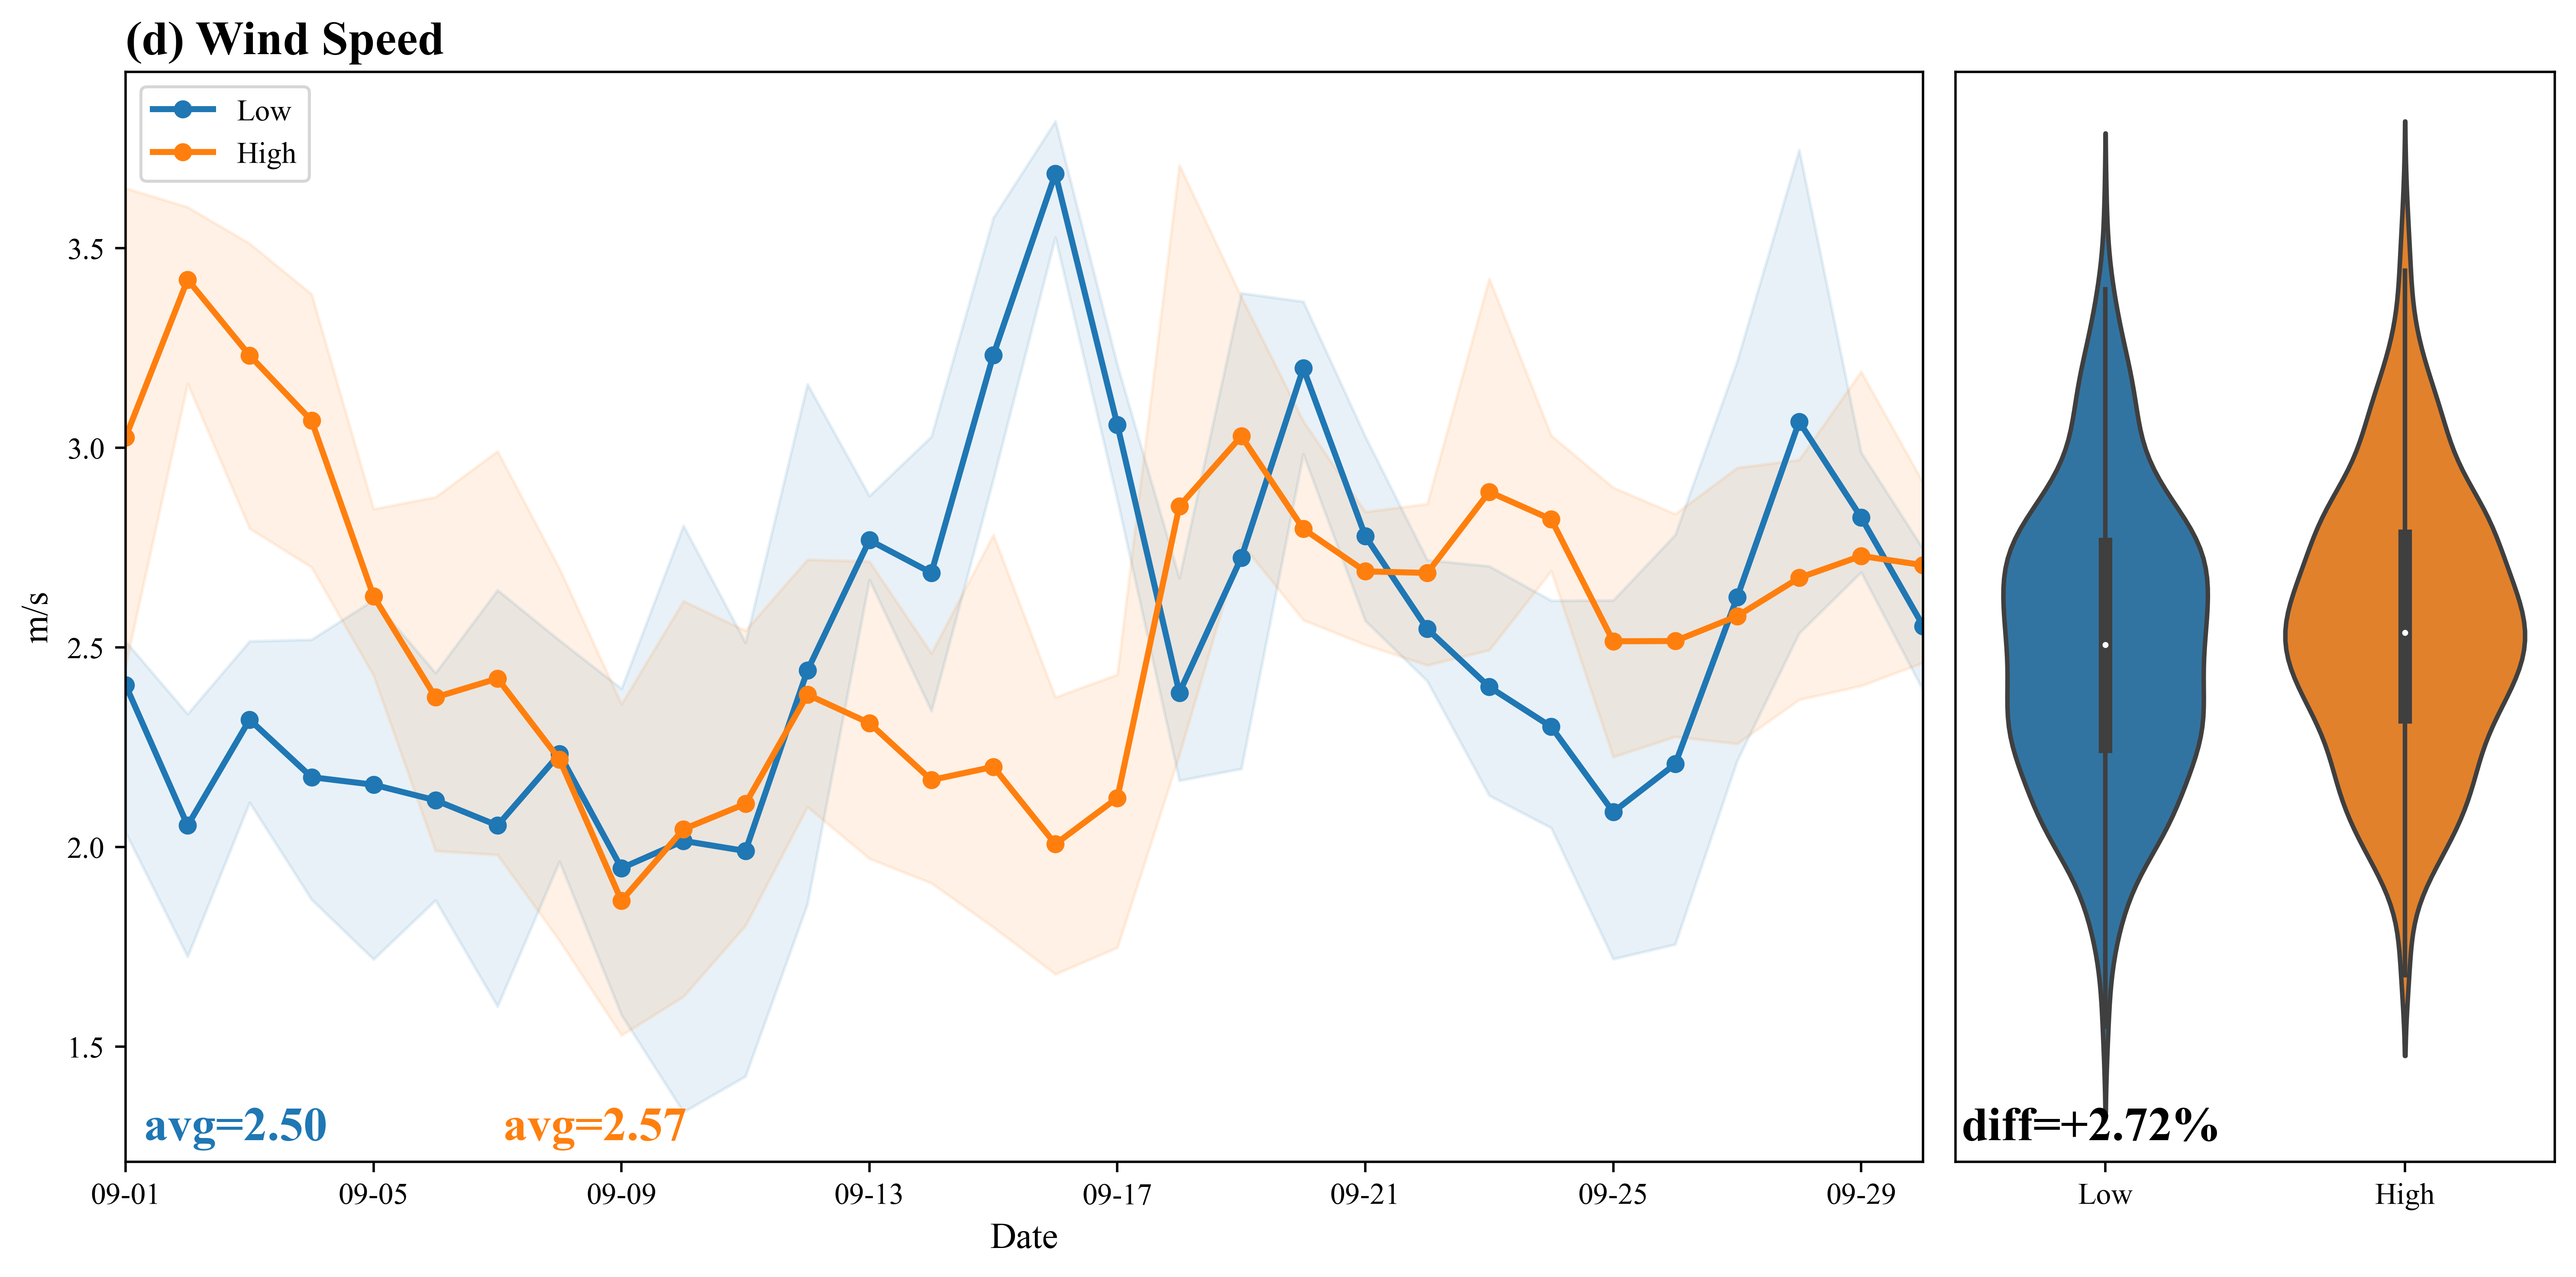

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=500, gridspec_kw={'width_ratios': [3, 1]})

xx = np.arange(0, len(mean_night_low.time), 1)
# lower years
ax1.plot(xx, mean_night_low, color='tab:blue', linewidth=2, label='Low', marker='.', markersize=10)
ax1.fill_between(xx, night_low_80per, night_low_20per, color='tab:blue', alpha=0.1)

ax1.plot(xx, mean_night_high, color='tab:orange', linewidth=2, label='High', marker='.', markersize=10)
ax1.fill_between(xx, night_high_80per, night_high_20per, color='tab:orange', alpha=0.1)

# ticks and labels
ax1.set_xlim([0, len(mean_night_low.time) - 1])
ax1.set_xticks(xx[::4])
ax1.set_xticklabels(pd.date_range('2023-09-01', '2023-09-30', freq='4D').strftime('%m-%d'))
ax1.set_xlabel('Date',fontsize=12)
ax1.set_ylabel('m/s',fontsize=12)
ax1.legend(loc=2)
ax1.set_title('(d) Wind Speed', loc='left', fontdict={'fontsize': 16, 'fontweight': 'bold'})

# 添加平均值数字
strdict = {'fontsize': 16, 'fontweight': 'bold'}
avg_low_str = '{:.2f}'.format(avg_night_low.mean())
avg_high_str = '{:.2f}'.format(avg_night_high.mean())
ax1.text(x=0.01, y=0.02, s=f'avg={avg_low_str}', color='tab:blue', fontdict=strdict, transform=ax1.transAxes)
ax1.text(x=0.21, y=0.02, s=f'avg={avg_high_str}', color='tab:orange', fontdict=strdict, transform=ax1.transAxes)

diff_str = '{:.2f}'.format((avg_night_high.mean() - avg_night_low.mean()) / avg_night_low.mean() *100)
if float(diff_str)>0:
    ax2.text(x=0.01, y=0.02, s=f'diff=+{diff_str}%', color='k', fontdict=strdict, transform=ax2.transAxes)
else:
    ax2.text(x=0.01, y=0.02, s=f'diff={diff_str}%', color='k', fontdict=strdict, transform=ax2.transAxes)
    
# 图2：小提琴图
df_box = pd.DataFrame({'Low': avg_night_low.values, 'High': avg_night_high.values})

color_palette = sns.color_palette(["tab:blue", "tab:orange"])
sns.violinplot(data=df_box, palette=color_palette, ax=ax2)

ax2.set_yticks([])

plt.tight_layout()
plt.show()